In [10]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import warnings
from pandas.errors import PerformanceWarning
warnings.simplefilter(action='ignore', category=PerformanceWarning)
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# initialize parameters
starting_year_to_filter = 1963
end_year_to_filter = 2020
number_of_lookback_periods = 120
data_to_read_address = ["data/25_Portfolios_5x5_SizeBM_monthly.csv",
                        "data/25_Portfolios_5x5_SizeOP_monthly.csv",
                        "data/25_Portfolios_5x5_SizeINV_monthly.csv"]
factor_data_address = "data/F-F_Research_Data_5_Factors_2x3.csv"
number_of_PPs_to_consider = 3
number_of_PEPs_to_consider = 3
number_of_PAPs_to_consider = 3

def rank_and_map(df):
    # Make a copy to avoid modifying the original DataFrame
    df_copy = df.copy()
    # Exclude the 'date' column for ranking
    data_columns = df_copy.columns[1:]
    
    # Apply ranking and scaling row-wise (for each date)
    def rank_row(row):
        # Get the ranks (min rank is 1)
        ranks = row.rank(method='min')
        # Normalize the ranks to range between 0 and 1
        ranks_normalized = (ranks - 1) / (len(row) - 1)
        # Map to range [-0.5, 0.5]
        return ranks_normalized - 0.5
    
    # Apply rank_row function to each row, excluding the 'date' column
    df_copy[data_columns] = df_copy[data_columns].apply(rank_row, axis=1)
    return df_copy


def cross_sectional_demean(df):
    # Make a copy to avoid modifying the original DataFrame
    df_copy = df.copy()
    # Exclude the 'date' column
    data_columns = df_copy.columns[1:]
    
    # Apply demeaning row-wise (for each date)
    def demean_row(row):
        row_mean = row.mean()  # Compute the mean of the row
        return row - row_mean  # Subtract the mean from each element in the row
    
    # Apply demean_row function to each row, excluding the 'date' column
    df_copy[data_columns] = df_copy[data_columns].apply(demean_row, axis=1)
    return df_copy


def compute_rs_product(df1, df2):
    # Ensure the date columns match
    if not df1['date'].equals(df2['date']):
        raise ValueError("Date columns of both dataframes must match.")
    
  # Convert to numeric, set invalid values as NaN
    df1 = df1.astype({col: 'float64' for col in df1.columns if col != 'date'})
    df2 = df2.astype({col: 'float64' for col in df2.columns if col != 'date'})
    result = {}
    
    # Iterate over each row (each date)
    for index, date in enumerate(df1['date']):
        # Get the R vector (from df1) and S' vector (from df2) for the current date
        R = df1.iloc[index, 1:].values.reshape(-1, 1)  # n x 1 vector
        S_transpose = df2.iloc[index, 1:].values.reshape(1, -1)  # 1 x n vector
        # Compute the outer product (RS')
        matrix_rs = np.dot(R, S_transpose)  # n x n matrix
        # Store the result in a dictionary, with date as the key
        result[date] = matrix_rs

    return result


def get_prediction_matrix(input_date, result_matrices, n_periods):
    # Sort the dates in result_matrices to ensure they're in order
    sorted_dates = sorted(result_matrices.keys())
    # Find the index of the input date in the sorted list of dates
    if input_date not in sorted_dates:
        raise ValueError("The input date is not found in the result_matrices.")
    
    input_date_index = sorted_dates.index(input_date)
    # Select the last n_periods (excluding the input date)
    start_index = max(0, input_date_index - n_periods)  # Ensure we don't go below index 0
    selected_dates = sorted_dates[start_index:input_date_index]
    
    if len(selected_dates) == 0:
        raise ValueError(f"There are no previous periods to calculate the average for the given number: {n_periods}.")
    
    # Initialize a matrix to accumulate the sum
    matrix_shape = result_matrices[sorted_dates[0]].shape
    sum_matrix = np.zeros(matrix_shape, dtype=float)
    # Sum all the selected matrices
    for date in selected_dates:
        sum_matrix += np.array(result_matrices[date], dtype=float)
    
    # Calculate the element-wise average
    average_matrix = sum_matrix / len(selected_dates)
    return average_matrix


# i should start from 0. In other words, to get the first PP's expected return you must set i=0.
def get_ith_PPs_expected_return(S,i):
    return S[i]

# i should start from 0. In other words, to get the first PP you must set i=0.
def get_ith_position_matrix(U,VT,i):
    u_column = U[:, i]
    v_column = VT[i, :]
    return np.outer(v_column,u_column)

def first_n_PPs_expected_return(S,n):
    sum = 0
    for i in range(n):
        sum += get_ith_PPs_expected_return(S,i)
    return sum

def first_n_PPs_position_matrix(U,VT,number_of_PPs):
    matrix_shape = U.shape
    sum_matrix = np.zeros(matrix_shape, dtype=float)
    for i in range(number_of_PPs):
        sum_matrix += get_ith_position_matrix(U,VT,i)
    return sum_matrix/number_of_PPs


# i should start from 0. In other words, to get the first PEP you must set i=0.
def get_ith_PEPs_expected_return(eigenvalues,i):
    return eigenvalues[i]

def get_ith_symmetric_position_matrix(eigenvectors,i):
    w = eigenvectors[:, i]
    return np.outer(w,w)

def first_n_PEPs_expected_return(eigenvalues,n):
    sum = 0
    for i in range(n):
        sum += abs(get_ith_PEPs_expected_return(eigenvalues,i))
    return sum

def first_n_PEPs_position_matrix(eigenvectors,number_of_PEPs):
    matrix_shape = eigenvectors.shape
    sum_matrix = np.zeros(matrix_shape, dtype=float)
    for i in range(number_of_PEPs):
        sum_matrix += get_ith_symmetric_position_matrix(eigenvectors,i)
    return sum_matrix/number_of_PEPs

# i should start from 0. In other words, to get the first PEP you must set i=0.
def get_ith_PAPs_expected_return(filtered_eigenvalues_ta,i):
    return 2 * filtered_eigenvalues_ta[i]

def get_ith_asymmetric_position_matrix(sorted_eigenvectors_ta_real_part,sorted_eigenvectors_ta_imaginary_part,i):
    return np.outer(sorted_eigenvectors_ta_real_part[:,i],sorted_eigenvectors_ta_imaginary_part[:,i]) - np.outer(sorted_eigenvectors_ta_imaginary_part[:,i],sorted_eigenvectors_ta_real_part[:,i])
    
def first_n_PAPs_expected_return(filtered_eigenvalues_ta,n):
    sum = 0
    for i in range(n):
        sum += get_ith_PAPs_expected_return(filtered_eigenvalues_ta,i)
    return sum

def first_n_PAPs_position_matrix(sorted_eigenvectors_ta_real_part,sorted_eigenvectors_ta_imaginary_part,number_of_PAPs):
    number_of_rows = sorted_eigenvectors_ta_real_part.shape[0]
    sum_matrix = np.zeros((number_of_rows,number_of_rows), dtype=float)
    for i in range(number_of_PAPs):
        sum_matrix += get_ith_asymmetric_position_matrix(sorted_eigenvectors_ta_real_part,sorted_eigenvectors_ta_imaginary_part,i)
    return sum_matrix/number_of_PAPs

def calculate_sharpe_ratio(returns):
    # Compute excess returns
    
    # Compute average excess return
    average_return = returns.mean()
    
    # Compute standard deviation of returns
    std_dev_returns = returns.std()
    
    # Compute Sharpe Ratio
    sharpe_ratio = average_return / std_dev_returns
    
    return sharpe_ratio

def filter_dataframes_by_common_dates(df1, df2):
    # Find common dates (intersection of index values)
    common_dates = df1.index.intersection(df2.index)
    
    # Filter both dataframes to keep only the rows with the common dates
    df1_filtered = df1.loc[common_dates]
    df2_filtered = df2.loc[common_dates]
    
    return df1_filtered, df2_filtered


def regression_results(X, Y):
    # Get the standard deviation of X[1] (which is the first non-constant column of X)
    std_X1 = X.iloc[:, 1].std()  # Assuming X[1] is the first non-constant column

    # Scale Y to have the same standard deviation as X[1]
    std_Y = Y.std()
    Y_scaled = Y * (std_X1 / std_Y)  # Scale Y by the ratio of std_X1 to std_Y

    # Add a constant (intercept) to the independent variables
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(Y_scaled, X).fit()

    # Get the coefficients (including the intercept)
    coefficients = model.params.values


    # Get the t-statistics
    t_stats = model.tvalues.values

    # Calculate the standard deviation of residuals
    residuals = model.resid
    std_residuals = residuals.std(ddof=1)  # Sample standard deviation (ddof=1)

    # Calculate intercept divided by standard deviation of residuals
    intercept_over_std_residuals = (coefficients[0] / std_residuals) * math.sqrt(12) #sqrt(12) is to make the IR annualized. again, to make comparison with Kelly's paper easier.

    # Get the R-squared value
    r_squared = model.rsquared

    coefficients[0] = coefficients[0] * 12 # This is to make the results comparable to Kelly(2022). They report annualized alphas in their tables.

    # Get the names of the independent variables (including the constant)
    variable_names = X.columns.tolist()

    # Return the list as required
    return [coefficients, t_stats, intercept_over_std_residuals, r_squared, variable_names]



def build_PP(data_to_read_address, factor_data_address):
    
    # Reading FF factor data
    factor_data_monthly = pd.read_csv(factor_data_address)
    factor_data_monthly['date'] = pd.to_datetime(factor_data_monthly['date'], format='%Y%m') + pd.offsets.MonthEnd(1)
    factor_data_monthly = factor_data_monthly.set_index("date")

    # Reading asset returns.
    portfolios_dataset_df = pd.read_csv(data_to_read_address)
    portfolios_dataset_df['date'] = pd.to_datetime(portfolios_dataset_df['date'], format='%Y%m') + pd.offsets.MonthEnd(1)
    
    signal_df = pd.DataFrame()
    signal_df["date"] = portfolios_dataset_df["date"]
    # Note that I shift signals one period forward to make computations easier. 
    signal_df= signal_df.join(portfolios_dataset_df.iloc[:, 1:].shift(1))
    # I can think of this matrix as $S_{t-1}$.
    normalized_signal_df = rank_and_map(signal_df)
    normalized_signal_df = normalized_signal_df[(normalized_signal_df['date'].dt.year > starting_year_to_filter) & (normalized_signal_df['date'].dt.year < end_year_to_filter)].reset_index(drop=True)
    # This matrix can be denoted as $R_{t-1}$
    demeaned_return_df = cross_sectional_demean(portfolios_dataset_df)
    demeaned_return_df = demeaned_return_df[(demeaned_return_df['date'].dt.year > starting_year_to_filter) & (demeaned_return_df['date'].dt.year < end_year_to_filter)].reset_index(drop=True)
    # This gives: $R_{t}S'_{t}$
    rs_matrix = compute_rs_product(demeaned_return_df, normalized_signal_df)
    
    """
    Prediction matrix for date T+1, used returns data up to month T and signals data up to month T-1.
    In the function get_prediction_matrix, I start the calculations from the previous month. 
    Note that although the input date is the current data, but the in the function that month is excluded.
    Note that in calculating realized returns, I am using the current month(the month of rearlized returns) as index. 
    But remember that the matrix was $S_{t-1}$. So, the index actually retreives the value of the previous month. 
    I formed the matrix this way in order to make the calculations easier.
    """

    realized_returns_df = pd.DataFrame(columns=[
        "date",
        "return_of_simple_factor", 
        "realized_return_of_first_three_PP", 
        "expected_return_of_first_three_PP",
        "realized_return_of_first_three_PEP",
        "expected_return_of_first_three_PEP",
        "realized_return_of_first_three_PAP",
        "expected_return_of_first_three_PAP"
    ])

    # I leave out the first 120 (number of lookback periods) observations to compute the prediction matrix.
    for date_index in demeaned_return_df.iloc[number_of_lookback_periods:]['date']:
        date_to_consider = pd.Timestamp(date_index)
        
        #for PP's
        prediction_matrix = get_prediction_matrix(date_to_consider, rs_matrix, number_of_lookback_periods)
        U, S, VT = np.linalg.svd(prediction_matrix)

        #for PEP's
        Symmetric_prediction_matrix = (prediction_matrix + prediction_matrix.T)/2
        eigenvalues, eigenvectors = np.linalg.eig(Symmetric_prediction_matrix)
        idx = eigenvalues.argsort()[::-1]  # Sort in descending order
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # for PAP'S
        assymetric_prediction_matrix = 0.5 * (prediction_matrix - prediction_matrix.T)
        transposed_assymetric_prediction_matrix = assymetric_prediction_matrix.T
        eigenvalues_ta, eigenvectors_ta = np.linalg.eig(transposed_assymetric_prediction_matrix)
        sorted_indices_ta = np.argsort(-eigenvalues_ta.imag)
        sorted_eigenvalues_ta = eigenvalues_ta[sorted_indices_ta].imag
        sorted_eigenvectors_ta = eigenvectors_ta[:, sorted_indices_ta] * math.sqrt(2)  #sqrt(2) is to make the size of the vectors equal to 1.
        positive_indices = np.where(sorted_eigenvalues_ta > 0)
        filtered_eigenvalues_ta = sorted_eigenvalues_ta[positive_indices]
        filtered_eigenvectors_ta = sorted_eigenvectors_ta[:, positive_indices].squeeze()
        sorted_eigenvectors_ta_imaginary_part = filtered_eigenvectors_ta.imag
        sorted_eigenvectors_ta_real_part = filtered_eigenvectors_ta.real

        #to calculate realized returns
        signal_vector = normalized_signal_df[normalized_signal_df.date == date_to_consider].values[0, 1:].reshape(1, -1)  # 1*n matrix
        return_vector = portfolios_dataset_df[portfolios_dataset_df.date == date_to_consider].values[0, 1:].reshape(-1, 1)  # n*1  # there is not much difference between using demeaned returns or not_demeaned ones. I can replace portfolios_dataset_df with demeaned_return_df.
        

        # Compute realized returns
        return_of_simple_factor = (signal_vector @ return_vector)[0][0]
        realized_return_of_first_three_PP = (signal_vector @ first_n_PPs_position_matrix(U, VT, number_of_PPs_to_consider) @ return_vector)[0][0]
        expected_return_of_first_three_PP = first_n_PPs_expected_return(S, number_of_PPs_to_consider)
        realized_return_of_first_three_PEP = (signal_vector @ first_n_PEPs_position_matrix(eigenvectors,number_of_PEPs_to_consider) @ return_vector)[0][0]
        expected_return_of_first_three_PEP = first_n_PEPs_expected_return(eigenvalues, number_of_PEPs_to_consider)
        realized_return_of_first_three_PAP = (signal_vector @ first_n_PAPs_position_matrix(sorted_eigenvectors_ta_real_part,sorted_eigenvectors_ta_imaginary_part,number_of_PAPs_to_consider) @ return_vector)[0][0]
        expected_return_of_first_three_PAP = first_n_PAPs_expected_return(filtered_eigenvalues_ta, number_of_PAPs_to_consider)
        

        # Prepare a list for the current row values
        row_values = [
            date_index,
            return_of_simple_factor,  
            realized_return_of_first_three_PP, 
            expected_return_of_first_three_PP,
            realized_return_of_first_three_PEP,
            expected_return_of_first_three_PEP,
            realized_return_of_first_three_PAP,
            expected_return_of_first_three_PAP
        ]

        # Iterate over all Principal Portfolios (up to len(S)) and calculate realized/expected returns for each
        for i in range(len(S)):

            # for PP's
            realized_return_ith_PP = (signal_vector @ get_ith_position_matrix(U, VT, i) @ return_vector)[0][0]
            expected_return_ith_PP = get_ith_PPs_expected_return(S, i)
            # Add the values for realized and expected returns of the ith PP to the row
            row_values.append(realized_return_ith_PP)
            row_values.append(expected_return_ith_PP)

            # for PEP's
            realized_return_ith_PEP = (signal_vector @ get_ith_symmetric_position_matrix(eigenvectors, i) @ return_vector)[0][0]
            expected_return_ith_PEP = get_ith_PEPs_expected_return(eigenvalues, i)
            # Add the values for realized and expected returns of the ith PEP to the row
            row_values.append(realized_return_ith_PEP)
            row_values.append(expected_return_ith_PEP)


            # Dynamically add columns if they don't exist. for PP's.
            realized_col_name_pp = f"realized_return_of_{i+1}_PP"
            expected_col_name_pp = f"expected_return_of_{i+1}_PP"

            # Dynamically add columns if they don't exist. for PEP's.
            realized_col_name_pep = f"realized_return_of_{i+1}_PEP"
            expected_col_name_pep = f"expected_return_of_{i+1}_PEP"
            
            # for PP's
            if realized_col_name_pp not in realized_returns_df.columns:
                realized_returns_df[realized_col_name_pp] = None
            if expected_col_name_pp not in realized_returns_df.columns:
                realized_returns_df[expected_col_name_pp] = None

            #for PEP'S
            if realized_col_name_pep not in realized_returns_df.columns:
                realized_returns_df[realized_col_name_pep] = None
            if expected_col_name_pep not in realized_returns_df.columns:
                realized_returns_df[expected_col_name_pep] = None
                
        # The number of PAP's is different, so another loop is needed.
        for i in range(sorted_eigenvectors_ta_imaginary_part.shape[1]):
            # for PAP's
            realized_return_ith_PAP = (signal_vector @ get_ith_asymmetric_position_matrix(sorted_eigenvectors_ta_real_part,sorted_eigenvectors_ta_imaginary_part,i) @ return_vector)[0][0]
            expected_return_ith_PAP = get_ith_PAPs_expected_return(filtered_eigenvalues_ta,i)
            # Add the values for realized and expected returns of the ith PEP to the row
            row_values.append(realized_return_ith_PAP)
            row_values.append(expected_return_ith_PAP)

            # Dynamically add columns if they don't exist. for PEP's.
            realized_col_name_pap = f"realized_return_of_{i+1}_PAP"
            expected_col_name_pap = f"expected_return_of_{i+1}_PAP"

            #for PAP'S
            if realized_col_name_pap not in realized_returns_df.columns:
                realized_returns_df[realized_col_name_pap] = None
            if expected_col_name_pap not in realized_returns_df.columns:
                realized_returns_df[expected_col_name_pap] = None

        # Append the row to the dataframe
        realized_returns_df.loc[len(realized_returns_df)] = row_values

    realized_returns_df = realized_returns_df.set_index("date")

    pap_std = realized_returns_df['realized_return_of_first_three_PAP'].std()
    pep_std = realized_returns_df['realized_return_of_first_three_PEP'].std()
    realized_returns_df['adjusted_PAP'] = realized_returns_df['realized_return_of_first_three_PAP'] * (pep_std / pap_std)
    # Take the average of the adjusted "PAP" and "PEP"
    realized_returns_df['PEP and PAP 1-3'] = (realized_returns_df['adjusted_PAP'] + realized_returns_df['realized_return_of_first_three_PEP']) / 2
    # drop the adjusted column.
    realized_returns_df.drop(columns='adjusted_PAP', inplace=True)

    sharpe_df = realized_returns_df.drop(realized_returns_df.filter(like="expected").columns, axis=1).apply(lambda col: calculate_sharpe_ratio(col)) * math.sqrt(12)

    pp_columns = realized_returns_df.filter(like="PP")
    pp_realized_mean_df = pp_columns.filter(like="realized").mean(axis=0)
    pp_expected_mean_df = pp_columns.filter(like="expected").mean(axis=0)

    pep_columns = realized_returns_df.filter(like="PEP")
    pep_realized_mean_df = pep_columns.filter(like="realized").mean(axis=0)
    pep_expected_mean_df = pep_columns.filter(like="expected").mean(axis=0)

    pap_columns = realized_returns_df.filter(like="PAP")
    pap_realized_mean_df = pap_columns.filter(like="realized").mean(axis=0)
    pap_expected_mean_df = pap_columns.filter(like="expected").mean(axis=0)

    output_dict = {
    'realized_returns_df': realized_returns_df,
    'sharpe_df': sharpe_df,
    'pp_realized_mean_df': pp_realized_mean_df,
    'pp_expected_mean_df': pp_expected_mean_df,
    'pep_realized_mean_df': pep_realized_mean_df,
    'pep_expected_mean_df': pep_expected_mean_df,
    'pap_realized_mean_df': pap_realized_mean_df,
    'pap_expected_mean_df': pap_expected_mean_df
    }

    
    realized_returns_df, factor_data_monthly = filter_dataframes_by_common_dates(realized_returns_df,factor_data_monthly)
    X = factor_data_monthly[['Mkt-RF', 'SMB','HML','RMW','CMA']]
    Y = realized_returns_df['return_of_simple_factor']
    output_dict["regression_result_return_of_simple_factor"] = regression_results(X,Y)

    # Following Kelly's paper. For regressions that have PP's as Y, simple factor must be addes as X.
    X = pd.concat([X, realized_returns_df['return_of_simple_factor']], axis=1)
    # List of column names in realized_returns_df for which I want to perform the regression
    columns_to_iterate = ['realized_return_of_first_three_PP',
                      'realized_return_of_first_three_PEP',
                      'realized_return_of_first_three_PAP',
                       'PEP and PAP 1-3'] 

    # Iterate over each column
    for col in columns_to_iterate:
        # Set Y to the column from realized_returns_df
        Y = realized_returns_df[col]
        # Store the results with a variable name based on the column name
        result_name = f'regression_result_{col}'
        output_dict[result_name] = regression_results(X,Y)
    return output_dict  


In [14]:
output_dict = {}
for dataset in data_to_read_address:
    output_dict[dataset.split("/")[1].split(".csv")[0]] = build_PP(dataset,factor_data_address)
# I calculate the results for all datasets. the results are stored in this dictionay.
print(output_dict.keys())
'''
Every value of this dictionary is itself another dictionary.
For instance the key 'sharpe_df' can be used to access the sharp values of this set of results.
'''
print(output_dict['25_Portfolios_5x5_SizeBM_monthly'].keys())
# output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]

Plotting the graphs

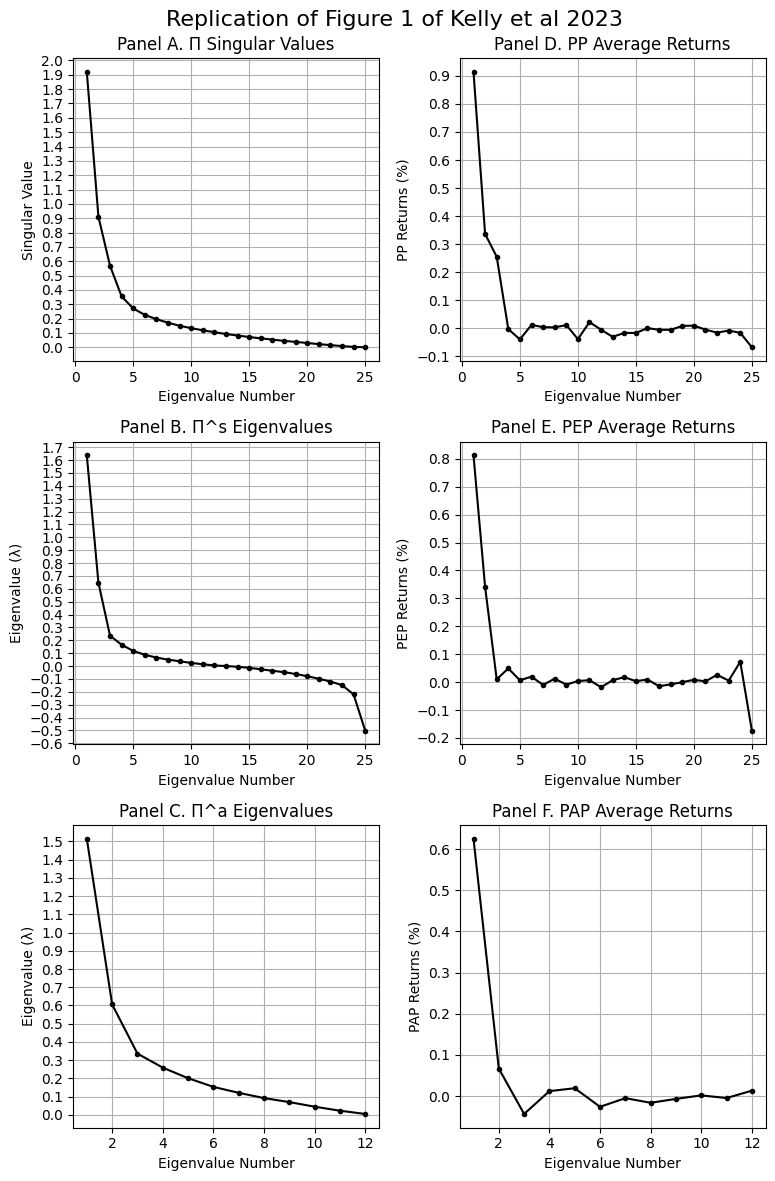

In [38]:
x = np.arange(1, 26)
singular_values = output_dict['25_Portfolios_5x5_SizeBM_monthly']["pp_expected_mean_df"][1:].values
eigenvalues_symmetric = output_dict['25_Portfolios_5x5_SizeBM_monthly']["pep_expected_mean_df"][1:].values
eigenvalues_antisymmetric = output_dict['25_Portfolios_5x5_SizeBM_monthly']["pap_expected_mean_df"][1:].values
pp_returns = output_dict['25_Portfolios_5x5_SizeBM_monthly']["pp_realized_mean_df"][1:].values
pep_returns = output_dict['25_Portfolios_5x5_SizeBM_monthly']["pep_realized_mean_df"][1:].values
pap_returns = output_dict['25_Portfolios_5x5_SizeBM_monthly']["pap_realized_mean_df"][1:].values

plt.rcParams['axes.grid'] = True
# Create 3x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(8, 12))  # 3 rows, 2 columns
y_ticks_granularity = np.arange(-0.5, 1.6, 0.1)

# Panel A: Singular values
axs[0, 0].plot(x, singular_values, 'k.-')
axs[0, 0].set_title('Panel A. Π Singular Values')
axs[0, 0].set_xlabel('Eigenvalue Number')
axs[0, 0].set_ylabel('Singular Value')

# Panel B: Symmetric eigenvalues
axs[1, 0].plot(x, eigenvalues_symmetric, 'k.-')
axs[1, 0].set_title('Panel B. Π^s Eigenvalues')
axs[1, 0].set_xlabel('Eigenvalue Number')
axs[1, 0].set_ylabel('Eigenvalue (λ)')

# Panel C: Antisymmetric eigenvalues
axs[2, 0].plot(np.arange(1, 13), eigenvalues_antisymmetric, 'k.-')
axs[2, 0].set_title('Panel C. Π^a Eigenvalues')
axs[2, 0].set_xlabel('Eigenvalue Number')
axs[2, 0].set_ylabel('Eigenvalue (λ)')

# Panel D: PP Average Returns
axs[0, 1].plot(x, pp_returns, 'k.-')
axs[0, 1].set_title('Panel D. PP Average Returns')
axs[0, 1].set_xlabel('Eigenvalue Number')
axs[0, 1].set_ylabel('PP Returns (%)')

# Panel E: PEP Average Returns
axs[1, 1].plot(x, pep_returns, 'k.-')
axs[1, 1].set_title('Panel E. PEP Average Returns')
axs[1, 1].set_xlabel('Eigenvalue Number')
axs[1, 1].set_ylabel('PEP Returns (%)')

# Panel F: PAP Average Returns
axs[2, 1].plot(np.arange(1, 13), pap_returns, 'k.-')
axs[2, 1].set_title('Panel F. PAP Average Returns')
axs[2, 1].set_xlabel('Eigenvalue Number')
axs[2, 1].set_ylabel('PAP Returns (%)')

for ax in axs.flat:
    ax.yaxis.set_major_locator(MultipleLocator(0.1)) 

# Add a title for the entire figure
fig.suptitle('Replication of Figure 1 of Kelly et al 2023 (page 29)', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


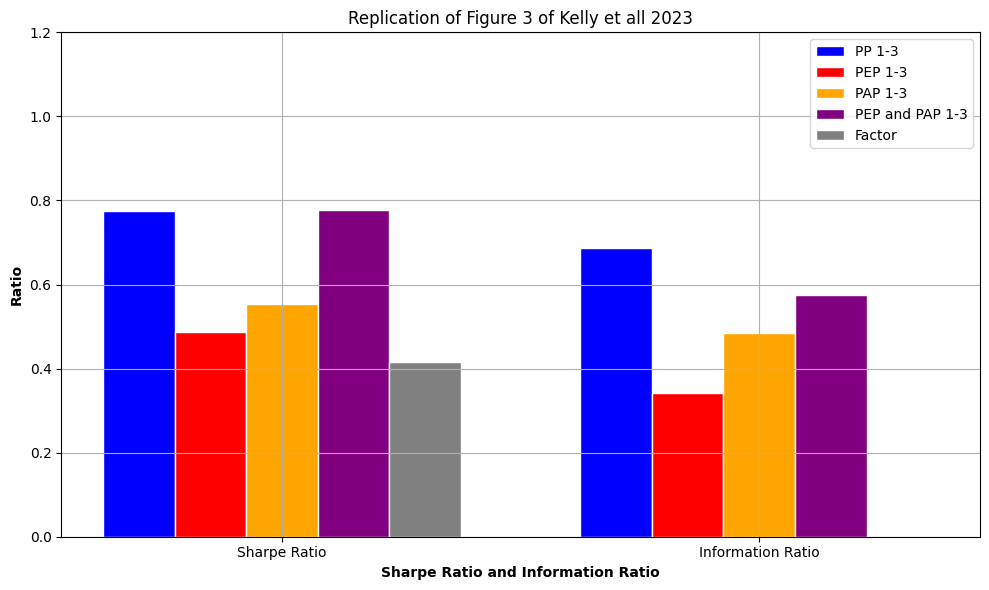

In [65]:
categories = ['Sharpe Ratio', 'Information Ratio']
bar_width = 0.15

# Data for each group (Sharpe Ratio and Information Ratio)
means_pp = [output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"].get('realized_return_of_first_three_PP'),
            output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PP"][2]]
means_pep = [output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"].get('realized_return_of_first_three_PEP'),
              output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PEP"][2]]
means_pap = [output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"].get('realized_return_of_first_three_PAP'),
              output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PAP"][2]]
means_pep_pap = [output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"].get('PEP and PAP 1-3'),
                 output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_PEP and PAP 1-3"][2]]
means_factor = [output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"].get('return_of_simple_factor'),0]

# The position of the bars on the x-axis
r1 = np.arange(len(categories))  # for PP
r2 = [x + bar_width for x in r1]  # for PEP
r3 = [x + bar_width for x in r2]  # for PAP
r4 = [x + bar_width for x in r3]  # for PEP and PAP
r5 = [x + bar_width for x in r4]  # for Factor

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each category without error bars
ax.bar(r1, means_pp, color='blue', width=bar_width, edgecolor='white', label='PP 1-3')
ax.bar(r2, means_pep, color='red', width=bar_width, edgecolor='white', label='PEP 1-3')
ax.bar(r3, means_pap, color='orange', width=bar_width, edgecolor='white', label='PAP 1-3')
ax.bar(r4, means_pep_pap, color='purple', width=bar_width, edgecolor='white', label='PEP and PAP 1-3')
ax.bar(r5, means_factor, color='gray', width=bar_width, edgecolor='white', label='Factor')

# Setting maximum value of Y-axis
ax.set_ylim([0, 1.2])
# Add labels
ax.set_xlabel('Sharpe Ratio and Information Ratio', fontweight='bold')
ax.set_ylabel('Ratio', fontweight='bold')
ax.set_title('Replication of Figure 3 of Kelly et all 2023 (page 31)')

# Add ticks on the x-axis
ax.set_xticks([r + 2*bar_width for r in range(len(categories))])
ax.set_xticklabels(categories)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


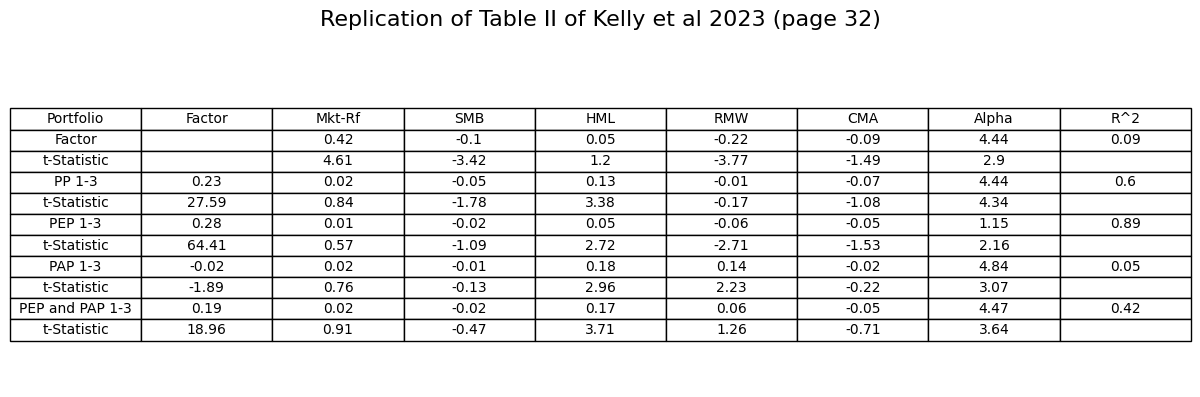

In [113]:
import pandas as pd


# Define the data as a series of lists (each list is a row)
rows = [
    ['Factor',''] + 
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_return_of_simple_factor"][0].tolist()]
    + [round(output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_return_of_simple_factor"][3],2)],
    ['t-Statistic',''] + [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_return_of_simple_factor"][1].tolist()] + [''] ,

    ['PP 1-3'] + 
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PP"][0].tolist()] +
    [round(output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PP"][3],2)],
    ['t-Statistic'] + [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PP"][1].tolist()] ,

    ['PEP 1-3']+
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PEP"][0].tolist()]+
    [round(output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PEP"][3],2)],
    ['t-Statistic'] + [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PEP"][1].tolist()],

    ['PAP 1-3']+
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PAP"][0].tolist()]+
    [round(output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PAP"][3],2)],
    ['t-Statistic'] + [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_three_PAP"][1].tolist()],

    ['PEP and PAP 1-3'] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_PEP and PAP 1-3"][0].tolist()]+
    [round(output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_PEP and PAP 1-3"][3],2)],
    ['t-Statistic'] + [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_PEP and PAP 1-3"][1].tolist()]
]

# My ordering of columns when saving the results of regressions is different from Kelly's paper. I do this to make comparison's easier.
rows[0][7],rows[0][2] = rows[0][2], rows[0][7]
rows[1][7],rows[1][2] = rows[1][2], rows[1][7]
for row in rows[2:]:
    row[1], row[7] = row[7], row[1]  

# Define the column names
columns = ['Portfolio', 'Factor', 'Mkt-Rf', 'SMB', 'HML', 'RMW', 'CMA', 'Alpha','R^2']

# Convert the rows into a pandas DataFrame
df = pd.DataFrame(rows, columns=columns)

# Create a matplotlib figure to render the table
fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Create the table and display it
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Set font size and adjust the scale of the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

fig.suptitle("Replication of Table II of Kelly et al 2023 (page 32)", fontsize=16)

# Adjust layout to prevent overlap between title and table
plt.tight_layout()

# Adjust the title position to avoid overlap with the table
fig.subplots_adjust(top=0.85)


plt.show()
